In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

# TEST QSH


In [3]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean.npy'
try: qsh.load(file)
except: raise FileNotFoundError

qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
# qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])  ## use this for Br_rm
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm','absBr_rs','argBr_rs']) 

# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [4]:
# Bt_min, Bt_max = np.nanmin(qsh['Bt_rm']), np.nanmax(qsh['Bt_rm'])
Br_min, Br_max = np.nanmin(qsh['Br_rm']), np.nanmax(qsh['Br_rm'])

def _map(xy,p,Br):
    # Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    # return (xy,pBtBr),(xy,pBtBr)
    return pBr,xy

# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm']).map(lambda x,y,br: _map(x,y,br) )
ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rm']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

W0904 12:06:18.719609 140459226920768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(<tf.Tensor: id=60, shape=(1, 24), dtype=float32, numpy=
 array([[0.7407136 , 0.71627575, 0.6264978 , 0.7639677 , 0.7001197 ,
         0.28148696, 0.29067883, 0.26306054, 0.29256448, 0.28120527,
         0.2768969 , 0.2706583 , 0.26852173, 0.29320186, 0.5020213 ,
         0.2808972 , 0.28108853, 0.31383452, 0.2949348 , 0.28584003,
         0.2850649 , 0.27620375, 0.27563307, 0.28641436]], dtype=float32)>,
 <tf.Tensor: id=61, shape=(1, 30), dtype=float32, numpy=
 array([[0.06339985, 0.1049374 , 0.15516752, 0.20822442, 0.27422595,
         0.34855986, 0.4316761 , 0.51310915, 0.59586084, 0.67665076,
         0.7538546 , 0.8198561 , 0.8769345 , 0.92538434, 0.95944905,
         0.24110314, 0.24755636, 0.26454723, 0.27094463, 0.27264637,
         0.27609128, 0.26078022, 0.259859  , 0.2540745 , 0.24817897,
         0.25445133, 0.23305716, 0.23637931, 0.23402068, 0.24097556]],
       dtype=float32)>)

In [5]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
vae.build(input_shape=vae.inference_net.input_shape)
vae.compile( vae.optimizer, tf.losses.mse )


AEFIT5 a ready:


In [ ]:
dds = ds.map(lambda p,xy: (xy,xy))
vae_history = vae.fit( dds.skip(5000).batch(100, drop_remainder=True), validation_data=dds.take(5000).batch(100), epochs=50)

In [6]:
# vae.save('step12_vae_ls')
vae.load('step12_vae_ls')
# plt.figure('vae_history')
# plt.plot(vae_history.history['loss'])
# plt.plot(vae_history.history['val_loss'])

In [7]:
vae1 = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=24, dprate=0.1, scale=2, geometry=[20,20,10,10])
vae1.generative_net.trainable = False
gen = vae1.inference_net

AEFIT5 a ready:


In [8]:
Dds = ds.map(lambda p,xy: (p, tf.reshape(vae.encode(tf.reshape(xy,[1,-1]),training=False)[0],[-1])) )
[x for x in Dds.batch(1).take(1)][0]

(<tf.Tensor: id=1488, shape=(1, 24), dtype=float32, numpy=
 array([[0.5767214 , 0.76863444, 0.7077146 , 0.5662365 , 0.2893917 ,
         0.29551372, 0.28522575, 0.28037414, 0.30292642, 0.32301083,
         0.3019124 , 0.31951934, 0.29237807, 0.27027684, 0.3772331 ,
         0.27391076, 0.2885698 , 0.30355185, 0.27136824, 0.2831127 ,
         0.29121977, 0.31283617, 0.30503005, 0.30405307]], dtype=float32)>,
 <tf.Tensor: id=1489, shape=(1, 6), dtype=float32, numpy=
 array([[ 0.0796762 , -0.7388474 ,  2.300649  ,  1.9987755 ,  1.293957  ,
         -0.27689657]], dtype=float32)>)

In [17]:

# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.
# l1_l2 = tf.keras.regularizers.l1_l2
# for l in gen.layers:
#     if issubclass(type(l), tf.keras.layers.Dense):
#         l.activity_regularizer = l1_l2(0.01)

# gen.compile( vae1.optimizer, vae1.loss )
gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )

DDS = Dds.prefetch( len(qsh) )


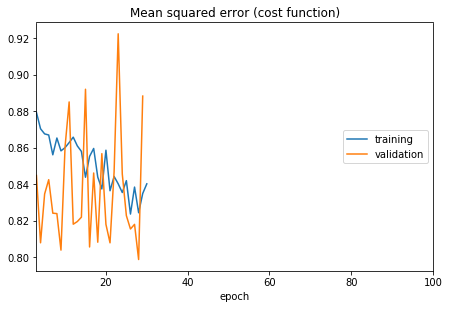

Mean squared error (cost function):
training   (min:    0.824, max:    0.881, cur:    0.840)
validation (min:    0.799, max:    0.922, cur:    0.888)
297/446 [==================>...........] - ETA: 28s - loss: 0.8402

In [18]:
fit = lambda: gen.fit( DDS.skip(3000).batch(100), validation_data=DDS.take(3000).batch(100), epochs=100,
                      callbacks=[PlotLossesCallback()] )
models.base.fn_thread(gen, fit).control_panel()

In [19]:
gen.layers[1].weights

[<tf.Variable 'aefi_t5_1_iRlv/kernel:0' shape=(24,) dtype=float32, numpy=
 array([ 0.9393965 ,  0.97131234,  0.89580446,  0.9382728 ,  0.9999999 ,
         0.15660961,  0.3456617 ,  0.85864747,  0.6846728 , -0.00664271,
         0.00230491,  0.585264  , -0.00257991,  0.11103495,  0.9510014 ,
         0.04471008,  0.55524343,  0.9602754 ,  0.6579287 ,  0.42195165,
         0.7833391 ,  0.19297856,  0.00484479,  0.11340409], dtype=float32)>]

 47/446 [==>...........................] - ETA: 1:51 - loss: 0.8192

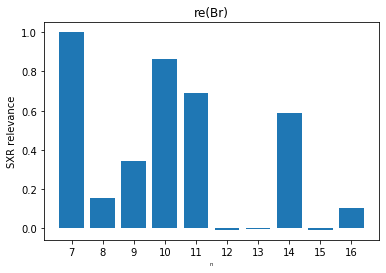

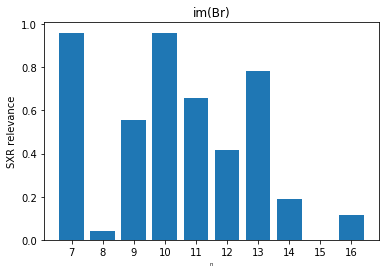

In [23]:
index = qsh[0].n
w = gen.layers[1].weights
%matplotlib inline

def plot_bar_x(index, w, title):
    # this is for plotting purpose
    plt.figure(title)
    plt.bar(index, w)
    plt.xlabel('n', fontsize=5)
    plt.ylabel('SXR relevance', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    plt.show()

re,im = w[0][4:14], w[0][14:24]
plot_bar_x(index, re, 're(Br)')
plot_bar_x(index, im, 'im(Br)')


In [24]:
# vae1.save('step12_vae1_p2SXR')
vae1.load('step12_vae1_p2SXR')
# vae.load('step12_gan_PBr_reim')

In [25]:
pos = 0

102


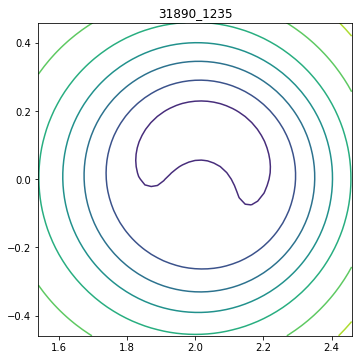

In [134]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]
qp = qsh[pos]
qp.plot_countour()


W0904 13:13:26.679346 140459226920768 legend.py:1282] No handles with labels found to put in legend.


102


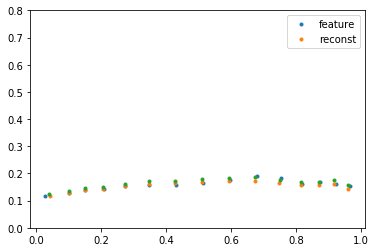

In [154]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]

def plot(xy, name=None):
    plt.figure('plot')
    ax = plt.gca()
    ax.legend()
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,'.', label=name)

xy = d_pos[1]
XY_vae = vae(xy, training=False)
ls = gen(d_pos[0], training=False)
XY = vae.decode(ls, training=False)
# XY = tf.sigmoid(XY)
plot(xy, 'feature')
plot(XY, 'reconst')
plot(XY_vae, 'vae')
# pos += 1

In [ ]:
plt.figure('Ip_error')
